# Tarea - Clasificacion Binaria de Pinturas para Auto

In [172]:
import random
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from optbinning import BinningProcess
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import BaggingClassifier

## 1 - Importación y Depuración de Datos

In [151]:
bronze_data = pd.read_excel('../Statement/datos_tarea25.xlsx')

silver_data = bronze_data.copy()  # Crear una copia del dataset original


### Binarizacion de variable objetivo

con el fin de manejar solo valores binarios en la variable objetivo definimos como 1 a White y 0 a Black

In [152]:
silver_data['Color'] = silver_data['Color'].map({'White': 1, 'Black': 0})

### Eliminar variables no representativas

El conjunto de datos no presenta variables identificadoras para eliminar pero la variable Wheel cuenta con solo dos valores de los cuales uno se lleva el 98% de las observaciones. Las RNN y espcialmente el algoritmo de maquinas de vector soporte es muy delicado a clases mal representadas por lo que eliminamos la propiedad 'Wheel' del conjunto de datos

In [153]:
silver_data = silver_data.drop(columns=['Wheel'])

### Definir tipo de datos

para cambiar las variables a el tipo de datos correcto en algunos casos tenemos que hacer algunas transformaciones sencillas. 
1. Para el caso de Mileage sacamos el sufijo 'km' de las observaciones 
2. Para el caso de 'Engine Volume' la transforme a numérica sacando la palabra 'Turbo' de done existe para poder lograr la conversion a tipo de dato numérico. Si bien es cierto que esta decision conlleva a una perdida de información la variable consta de 59 tipos de valores lo que conlleva a que ella clases mal representadas a un enorme gasto computacional porque, de ser categóricas, se transformaría en 58 variables dummys.
3. Para el caso de Airbags: la transformamos a categórica porque son solo 12 tipos de observaciones distintas y presentan saltos no lineales debido a que el aumento de los aibags suele estar relacionado con carecteristicas no lineales como el numero de pasajeros o las posiciones que se quieren asegurar
4. Para el caso de Leather Interior: la mapeamos como binaria ya que sus valores eran si o no. 

In [154]:
# Convertir las columnas a sus tipos de datos correctos
silver_data['Mileage'] = silver_data['Mileage'].str.replace(' km', '').str.replace(',', '').astype(float)  # Convertir Mileage a numérico
silver_data['Engine volume'] = silver_data['Engine volume'].str.replace(' Turbo', '').astype(float)  # Convertir Engine volume a numérico
silver_data['Airbags'] = silver_data['Airbags'].astype('category')
silver_data['Leather interior'] = silver_data['Leather interior'].map({'Yes': 1, 'No': 0})

Para el caso de la variable Levy decidimos tramificar debido a que hay pocas clases que concentran la mayoría de las observaciones y la gran cantidad de datos perdidos.

Para poder definir los tramos que mejor separen las observaciones en base a la variable objetivo 'Color'. El indice que utilizamos es el 'Information Value' usando como criterio un valor mínimo de 0.02 de información por cada tramo y un máximo de 5 tramos. 

Debido a que esta variable presentaba un 15% de datos perdidos decidimos añadir una sexta categoría que represente a todos los datos perdidos de manera que podamos captar la información que quizás la ausencia de valor para esa variable puede significar

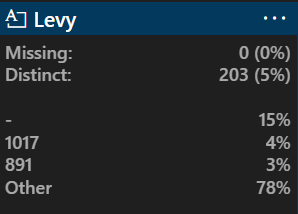

In [16]:
# Convertir las columnas a sus tipos de datos correctos
silver_data['Mileage'] = silver_data['Mileage'].str.replace(' km', '').str.replace(',', '').astype(float)  # Convertir Mileage a numérico
silver_data['Engine volume'] = silver_data['Engine volume'].str.replace(' Turbo', '').astype(float)  # Convertir Engine volume a numérico
silver_data['Prod. year'] = silver_data['Prod. year'].astype(int)  # Asegurar que Prod. year sea entero


In [155]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Reemplazar "-" por NaN y convertir a numérico
silver_data['Levy'] = silver_data['Levy'].replace("-", np.nan)
silver_data['Levy'] = pd.to_numeric(silver_data['Levy'], errors='coerce')

# Excluir valores nulos de Levy para el binning
non_null_data = silver_data[silver_data['Levy'].notnull()]

# Configurar el proceso de binning con el criterio de Information Value (IV)
binning_process = BinningProcess(
    variable_names=['Levy'],
    selection_criteria={"iv": {"min": 0.02}},
    max_n_bins=5  # Máximo número de bins permitido
)

# Ajustar el binning process a los datos no nulos
binning_process.fit(non_null_data[['Levy']], non_null_data['Color'])

# Obtener los puntos de corte (splits)
levy_binned = binning_process.get_binned_variable('Levy')
binning_table = levy_binned.binning_table
binning_table.build()
levy_splits = binning_table.splits

# Crear etiquetas personalizadas para los tramos
levy_bins_labels = [f"{float(lower)} - {float(upper)}" for lower, upper in zip([-float('inf')] + list(levy_splits), list(levy_splits) + [float('inf')])]

# Asignar las etiquetas personalizadas a los tramos
silver_data['Levy_bins'] = pd.cut(
    silver_data['Levy'],
    bins=[-float('inf')] + list(levy_splits) + [float('inf')],
    labels=levy_bins_labels,
    right=False
)

# Añadir un tramo específico para los valores nulos
silver_data['Levy_bins'] = silver_data['Levy_bins'].cat.add_categories("Missing")
silver_data['Levy_bins'].fillna("Missing", inplace=True)
silver_data = silver_data.drop(columns=['Levy'])

Para el caso de la variable 'Prod. year' quisimos también hacer una tramificación usando el Information value como criterio para encontrar los puntos de corte optimo pero después de mucho intentar parece haber un problema insalvable con los datos de la variable para poder ser tratados por la función que obtiene los tramos adecuados. 

Frente a esto y la conveniencia de tramificar ya que es una variable que es susceptible de tener saltos no lineales con respecto a la variable objetivo (por ejemplo una regulación que a partir de cierto año en la UE se promueve los autos blancos) decidimos tramificar la variable de manera manual, agrupando los poco autos viejos que había en el primer tramo y tener tramos mas pequeños de ahi en adelante. 

Debido a que la tramificación en este caso no era una decision tan obvia y es cuestionable decidimos mantener también la variable original de manera numérica en el conjunto de datos

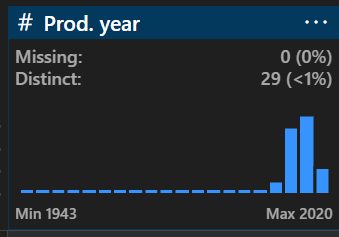

In [156]:
silver_data['Prod. year'] = pd.to_numeric(bronze_data['Prod. year'])

# Crear tramos manuales para 'Prod. year'
manual_bins = [1943, 2000, 2004, 2008, 2012, 2016, 2020]
manual_labels = ['1943-2000', '2001-2004', '2005-2008', '2009-2012', '2013-2016', '2017-2020']

# Asignar los tramos manuales a la columna 'Prod. year'
silver_data['Prod. year_bins'] = pd.cut(
    silver_data['Prod. year'],
    bins=manual_bins,
    labels=manual_labels,
    right=True,
    include_lowest=True 
)


### Tratamiento de valores missings

Para el caso de las variables categóricas imputamos en los valores perdidos la moda de cada variable. Para el caso de las variables numéricas imputamos el promedio en cada variable. Este cambio aplica para todas las demás variables que no fuero tratadas de manera especifica en los pasos previos

In [157]:
for column in silver_data.columns:
    if silver_data[column].dtype == 'object':  # Imputar moda para variables categóricas
        silver_data[column].fillna(silver_data[column].mode()[0], inplace=True)
    elif silver_data[column].dtype in ['int64', 'float64']:  # Imputar promedio para variables numéricas
        silver_data[column].fillna(silver_data[column].mean(), inplace=True)

## 2 - Modelización con maquina de vector soporte

### Valores dummies para cada variable categorica

Para cada variable categorica de nuestro conjunto de datos creamos n-1 variables diferentes siendo n el numero total de valores diferentes de la variable categorica en cuestion. 

In [158]:
# 2. Crear columnas dummys para variables categóricas
# Asegurarse de incluir todas las variables categóricas, incluidas las de tipo 'category'
categorical_cols = ['Levy_bins', 'Prod. year_bins', 'Airbags', 'Manufacturer', 'Category', 'Fuel type', 'Drive wheels', 'Gear box type',]  # Lista de columnas categóricas
silver_data = pd.get_dummies(silver_data, columns=categorical_cols, drop_first=True)


### Estandarización de variables continuas

Para mejorar la capacidad explicativa de las variables continuas en las RNN es importante estandarizarlas a todas aplicándoles la misma transformación. En este caso aplicamos la estandarización a escala, es decir las variables van a ir de 0 a 1. 

Si bien es cierto que esta transformación es menor fiel del punto de vista explicativo a la escala original que la transformación normal decidimos aplicar esta transformación porque es mejor para los fines predictivos y los RNN, al ser modelos de caja negra, adolecen, en gran medida, de capacidad explicativa mas no de su uso predictivo

In [159]:
# 3. Estandarizar variables continuas a escala [0, 1]
scaler = MinMaxScaler()
numerical_columns = silver_data.select_dtypes(include=['int64', 'float64']).columns
silver_data[numerical_columns] = scaler.fit_transform(silver_data[numerical_columns])

## 2 - Modelización con maquina de vector soporte

Dividimos los conjuntos de datos para train y test usando una semilla de aleatoriedad prefijada

In [160]:
Y = silver_data['Color'] 
X = silver_data.drop(columns=['Color'])
print("Variables explicativas: ", list(X.columns))
print("Variable objetivo: ", Y.name)

SEED = 12345
random.seed(SEED)
np.random.seed(SEED)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=SEED)

Variables explicativas:  ['Price', 'Prod. year', 'Leather interior', 'Engine volume', 'Mileage', 'Cylinders', 'Levy_bins_585.5 - 773.5', 'Levy_bins_773.5 - 932.0', 'Levy_bins_932.0 - 1349.0', 'Levy_bins_1349.0 - inf', 'Levy_bins_Missing', 'Prod. year_bins_2001-2004', 'Prod. year_bins_2005-2008', 'Prod. year_bins_2009-2012', 'Prod. year_bins_2013-2016', 'Prod. year_bins_2017-2020', 'Airbags_1', 'Airbags_2', 'Airbags_3', 'Airbags_4', 'Airbags_5', 'Airbags_6', 'Airbags_7', 'Airbags_8', 'Airbags_9', 'Airbags_10', 'Airbags_11', 'Airbags_12', 'Airbags_14', 'Airbags_15', 'Airbags_16', 'Manufacturer_LEXUS', 'Manufacturer_MERCEDES-BENZ', 'Manufacturer_TOYOTA', 'Category_Jeep', 'Category_Sedan', 'Fuel type_Hybrid', 'Fuel type_Petrol', 'Drive wheels_Front', 'Drive wheels_Rear', 'Gear box type_Tiptronic']
Variable objetivo:  Color


### Modelo SVM con kernel lineal

Usamos el modelo de maquina de vector soporte mas sencillo, el kernel lineal, el cual busca separar los conjuntos de los problemas de clasificación mediante una función lineal. Es bastante similar a un modelo de regresión lineal.

Para lograr un modelo mas robusto y con poco sesgo partimos de la premisa de mantenernos con una C pequeña de manera que el modelo tenga cierta tolerancia a observaciones mal clasificadas en la frontera de la separación.

Fuimos variando para encontrar el SVM lineal optimo

In [178]:
svm_linear = SVC(kernel='linear', C=0.1, random_state=SEED, probability=True)
svm_linear.fit(X_train, Y_train)
y_pred_linear = svm_linear.predict(X_test)
y_proba_linear = svm_linear.predict_proba(X_test)[:, 1]

print("Resultados SVM Kernel Lineal con C=0.1:")
print("Accuracy:", accuracy_score(Y_test, y_pred_linear))
print("AUC:", roc_auc_score(Y_test, y_proba_linear))
print(classification_report(Y_test, y_pred_linear))

Resultados SVM Kernel Lineal con C=0.1:
Accuracy: 0.6497695852534562
AUC: 0.6823523369286081
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67       590
         1.0       0.61      0.64      0.63       495

    accuracy                           0.65      1085
   macro avg       0.65      0.65      0.65      1085
weighted avg       0.65      0.65      0.65      1085



In [180]:
svm_linear = SVC(kernel='linear', C=0.5, random_state=SEED, probability=True)
svm_linear.fit(X_train, Y_train)
y_pred_linear = svm_linear.predict(X_test)
y_proba_linear = svm_linear.predict_proba(X_test)[:, 1]

print("Resultados SVM Kernel Lineal con C=0.5:")
print("Accuracy:", accuracy_score(Y_test, y_pred_linear))
print("AUC:", roc_auc_score(Y_test, y_proba_linear))
print(classification_report(Y_test, y_pred_linear))



Resultados SVM Kernel Lineal con C=0.5:
Accuracy: 0.6580645161290323
AUC: 0.6855743879472692
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68       590
         1.0       0.62      0.65      0.63       495

    accuracy                           0.66      1085
   macro avg       0.66      0.66      0.66      1085
weighted avg       0.66      0.66      0.66      1085



In [179]:
svm_linear = SVC(kernel='linear', C=2, random_state=SEED, probability=True)
svm_linear.fit(X_train, Y_train)
y_pred_linear = svm_linear.predict(X_test)
y_proba_linear = svm_linear.predict_proba(X_test)[:, 1]

print("Resultados SVM Kernel Lineal con C=2:")
print("Accuracy:", accuracy_score(Y_test, y_pred_linear))
print("AUC:", roc_auc_score(Y_test, y_proba_linear))
print(classification_report(Y_test, y_pred_linear))

Resultados SVM Kernel Lineal con C=2:
Accuracy: 0.6599078341013825
AUC: 0.6861171032357474
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68       590
         1.0       0.62      0.64      0.63       495

    accuracy                           0.66      1085
   macro avg       0.66      0.66      0.66      1085
weighted avg       0.66      0.66      0.66      1085



El mejor modelo SVM lineal es con la C es 2. Pero las mejoras son apenas perceptibles por lo que considero que no vale la pena seguirla aumentando en detrimento de la robustez del modelo. Un c pequeña siempre favorece a que el modelo tenga menor sesgo debido a que penaliza menos las observaciones mal clasificadas

### SVM con kernel Polinómico

Optamos por probar el kernel polinómico el cual intenta clasificar las observaciones mapeándolas a un plano de mayor grado y obteniendo una función polinómica de determinado grado para poder separar las observaciones .

Las variantes que se pueden probar en un SVM polinómico son entonces el grado del polinomio separador y la C que tiene la misma función que en el SVM lineal, es un penalizador de las observaciones mal clasificadas. Mientras mas alta mas el modelo intenta separar las observaciones siendo menos tolerantes a observaciones mal clasificadas.

Siguiendo la misma premisa de mantener la C relativamente baja para poder tener un modelo robusto y no tan sesgado probamos diferentes alternativas del svm polinómico

In [ ]:
svm_poly = SVC(kernel='poly', degree=2, C=2, random_state=SEED, probability=True)
svm_poly.fit(X_train, Y_train)
y_pred_poly = svm_poly.predict(X_test)
y_proba_poly = svm_poly.predict_proba(X_test)[:, 1]

print("Resultados SVM Kernel Polinómico de grado 2 y con C=2:")
print("Accuracy:", accuracy_score(Y_test, y_pred_poly))
print("AUC:", roc_auc_score(Y_test, y_proba_poly))
print(classification_report(Y_test, y_pred_poly))

Resultados SVM Kernel Polinómico de grado 3 y con C=2:
Accuracy: 0.687557603686636
AUC: 0.7411573360725904
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       590
         1.0       0.66      0.66      0.66       495

    accuracy                           0.69      1085
   macro avg       0.69      0.69      0.69      1085
weighted avg       0.69      0.69      0.69      1085



In [186]:
svm_poly = SVC(kernel='poly', degree=2, C=3, random_state=SEED, probability=True)
svm_poly.fit(X_train, Y_train)
y_pred_poly = svm_poly.predict(X_test)
y_proba_poly = svm_poly.predict_proba(X_test)[:, 1]

print("Resultados SVM Kernel Polinómico de grado 2 y con C=3:")
print("Accuracy:", accuracy_score(Y_test, y_pred_poly))
print("AUC:", roc_auc_score(Y_test, y_proba_poly))
print(classification_report(Y_test, y_pred_poly))

Resultados SVM Kernel Polinómico de grado 2 y con C=3:
Accuracy: 0.6894009216589861
AUC: 0.7426656394453005
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71       590
         1.0       0.66      0.67      0.66       495

    accuracy                           0.69      1085
   macro avg       0.69      0.69      0.69      1085
weighted avg       0.69      0.69      0.69      1085



In [187]:
svm_poly = SVC(kernel='poly', degree=3, C=2, random_state=SEED, probability=True)
svm_poly.fit(X_train, Y_train)
y_pred_poly = svm_poly.predict(X_test)
y_proba_poly = svm_poly.predict_proba(X_test)[:, 1]

print("Resultados SVM Kernel Polinómico de grado 3 y con C=2:")
print("Accuracy:", accuracy_score(Y_test, y_pred_poly))
print("AUC:", roc_auc_score(Y_test, y_proba_poly))
print(classification_report(Y_test, y_pred_poly))

Resultados SVM Kernel Polinómico de grado 3 y con C=2:
Accuracy: 0.7059907834101382
AUC: 0.7536380756719739
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       590
         1.0       0.68      0.67      0.68       495

    accuracy                           0.71      1085
   macro avg       0.70      0.70      0.70      1085
weighted avg       0.71      0.71      0.71      1085



Como podemos observar el SVM de grado 3 es algo superior tanto en el Area bajo de la curva ROC como también en la Precision de las predicciones

### Comparación de los kernels de SVM

Para poder observarlo de manera gráfica generamos un diagrama con las dos curvas AUC de los mejores configuraciones paramétricas de ambos kernels, el lineal y el polinómico

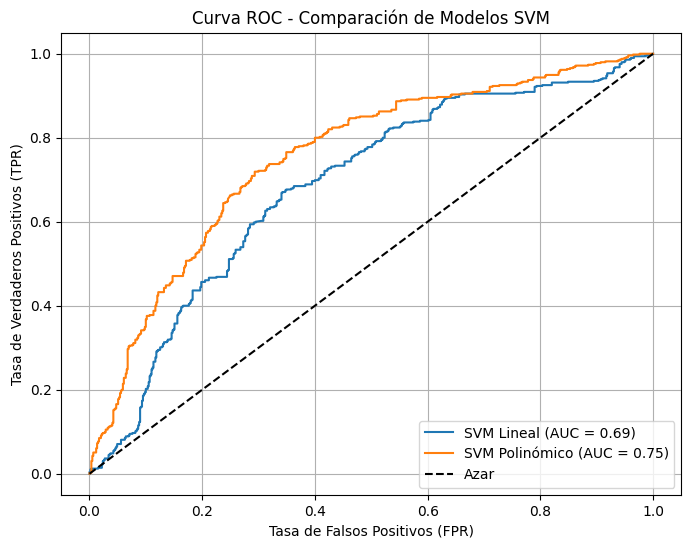

In [188]:
fpr_linear, tpr_linear, _ = roc_curve(Y_test, y_proba_linear)
fpr_poly, tpr_poly, _ = roc_curve(Y_test, y_proba_poly)

plt.figure(figsize=(8, 6))
plt.plot(fpr_linear, tpr_linear, label='SVM Lineal (AUC = {:.2f})'.format(roc_auc_score(Y_test, y_proba_linear)))
plt.plot(fpr_poly, tpr_poly, label='SVM Polinómico (AUC = {:.2f})'.format(roc_auc_score(Y_test, y_proba_poly)))
plt.plot([0, 1], [0, 1], 'k--', label='Azar')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Comparación de Modelos SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Como podemos observar ambos modelos son bastante buenos siendo el SVM Polinómico superior no solo en AUC sino también en Accuracy.

### Bagging del modelo ganador

Aplicando la técnica del Bagging al el modelo SVM polinómico nos aseguramos de reducir la varianza para poder tener un modelo mas robusto que se comporte de manera similar sin importar el conjunto de datos que reciba y que no este sesgado exclusivamente el conjunto de entrenamiento

Utilizaremos 10 modelos estimadores de kernel polinómico cada uno entrenado con diferentes conjuntos de datos(n_estimators). Cada uno de estos modelos se entrenara con el 80% de los datos (max_samples). Todos los modelos tendrán a disposición la totalidad de las características del conjunto de datos (max features). Las muestras de entrenamiento se obtienen seleccionando de manera aleatoria las observaciones permitiendo que una sea seleccionada en mas de una sesión de entrenamiento (boostrap)

In [ ]:
base_model = SVC(kernel='poly', probability=True, random_state=12345)

bagging_model = BaggingClassifier(
    estimator=base_model,
    n_estimators=10,  
    max_samples=0.8,  
    max_features=1.0,  
    bootstrap=True,  
    random_state=54321 # cambie la semilla de aleatoridad para reducir el sesgo
)

bagging_model.fit(X_train, Y_train)

y_pred_bagging = bagging_model.predict(X_test)
y_proba_bagging = bagging_model.predict_proba(X_test)[:, 1]

accuracy_bagging = accuracy_score(Y_test, y_pred_bagging)
auc_bagging = roc_auc_score(Y_test, y_proba_bagging)
report_bagging = classification_report(Y_test, y_pred_bagging)

print("Resultados Bagging sobre SVM Kernel Polinómico:")
print(f"Accuracy: {accuracy_bagging}")
print(f"AUC: {auc_bagging}")
print(report_bagging)

Resultados Bagging sobre SVM Kernel Polinómico:
Accuracy: 0.6903225806451613
AUC: 0.7603629515493924
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72       590
         1.0       0.67      0.63      0.65       495

    accuracy                           0.69      1085
   macro avg       0.69      0.69      0.69      1085
weighted avg       0.69      0.69      0.69      1085



El modelo obtenido es ligeramente mejor en el desempeño de el area bajo de la curva ROC y el accuracy es ligeramente inferior. Pero en ambos casos las medidas son casi idénticas el modelo SVM polinómico de grado 3 entrenado originalmente pero probablemente mas robusto antes nuevas observaciones al ser entrenado con un conjunto de datos superior y en un mayor numero de corridas